# Experiment 1

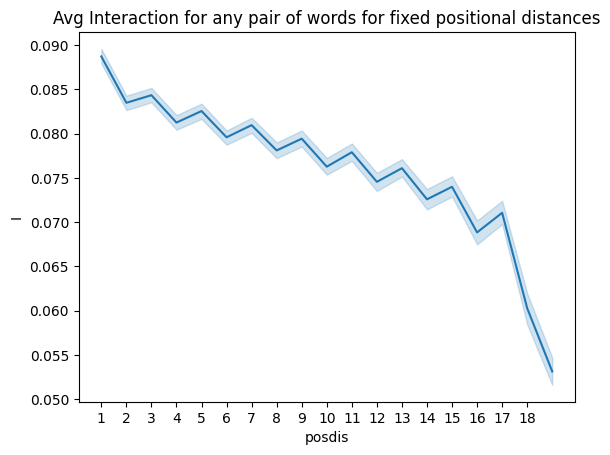

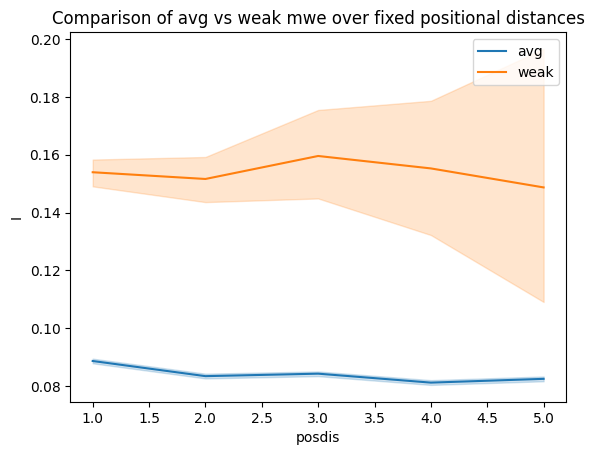

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_mean(avg_path='average_distance.pkl', weak_path='weak_mwe_distance.pkl', strong_path='strong_mwe_distance.pkl'):
    avg_dist = pd.read_pickle(avg_path)
    avg_df = pd.DataFrame(avg_dist, columns = ['I', 'posdis', 'ignore'])
    avg_df['posdis'] = avg_df['posdis'].astype(int)
    g = sns.lineplot(data=avg_df, x="posdis", y="I")
    g.set_title('Avg Interaction for any pair of words for fixed positional distances')
    g.set(xticks=list(range(1,19)))
    plt.show()
    weak_mwe_distance = pd.read_pickle(weak_path)
    weak_mwe_df = pd.DataFrame(weak_mwe_distance, columns = ['I', 'posdis', 'ignore'])
    weak_mwe_df = weak_mwe_df[weak_mwe_df['posdis']!=0].copy()
    weak_mwe_df['count'] = weak_mwe_df.groupby('posdis')['I'].transform(lambda x : x.count())
    weak_mwe_df = weak_mwe_df[weak_mwe_df['count']>=50].copy()
    weak_mwe_df['posdis'] = weak_mwe_df['posdis'].astype(int)
    avg_df = avg_df[avg_df['posdis']<=weak_mwe_df['posdis'].max()].copy()

    fig, ax = plt.subplots()
    avg_line = sns.lineplot(data=avg_df, x="posdis", y="I", ax=ax, label='avg')
    weak_line = sns.lineplot(data=weak_mwe_df, x="posdis", y="I", ax=ax, label='weak')
    ax.set_title('Comparison of avg vs weak mwe over fixed positional distances')
    ax.legend()
    # ax.legend(labels=['avg','weak'])
    
    g.set(xticks=list(range(1,6)))
    # strong_mwe_distance = pd.read_pickle(strong_path)
    # strong_mwe_df = pd.DataFrame(strong_mwe_distance, columns = ['I', 'posdis', 'ignore'])
    # strong_mwe_df['count'] = strong_mwe_df.groupby('posdis')['I'].count()
    # strong_mwe_df = strong_mwe_df[strong_mwe_df['count']>=50].copy()
    plt.show()
plot_mean()

# Experiment 2

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
def _filter_df(df, min_dist):
    df['min_dist'] = df['predicted_token_dist_from_start'] - df[['first_token', 'second_token']].max(axis=1)
    df = df[df['min_dist'] == min_dist].copy()
    return df

def f_df(path, min_dist=1, filter=True):
    abc = pd.read_pickle(path)
    abc['first_token'] = abc.apply(lambda x : x['ignore'][x['first_token']], axis=1)
    abc['second_token'] = abc.apply(lambda x : x['ignore'][x['second_token']], axis=1)
    # display(abc[abc['first_token'] == abc['second_token']].copy())
    
    abc = abc[abc['first_token'] != abc['second_token']].copy()
    abc['predicted_token_dist_from_start'] = abc.apply(lambda x : list(range(x['I'][1], x['I'][1] + len(x['I'][0]))), axis=1)
    abc['tensor'] = abc.apply(lambda x : x['I'][0], axis=1)
    abc = abc.explode(['predicted_token_dist_from_start', 'tensor']).drop(columns = ['I'])
    if filter:
        abc = _filter_df(abc, min_dist)
    abc['tensor'] = abc['tensor'].apply(lambda x : float(x))
    abc = abc.reset_index(drop=True)
    abc['count'] = abc.groupby('posdis')['row_number'].transform(lambda x : x.count())
    abc = abc[abc['count']>=50].copy()
    return abc

def f_avg_df(path = 'average_distance_3d.pkl', min_dist=1, filter=True):
    import pickle
    abc = pickle.load(open(path,'rb'))
    abc = pd.DataFrame(abc, columns = ['I', 'posdis', 'row_number', 'word_pair'])#'first_token', 'second_token'])
    abc = abc[abc['posdis']<=8].copy()
    abc[['first_token', 'second_token']] = abc['word_pair'].to_list()
    abc = abc[abc['first_token'] != abc['second_token']].copy()
    abc[['tensor', 'st_tok']] = abc['I'].to_list()
    abc['len'] = abc['tensor'].str.len()
    abc['predicted_token_dist_from_start'] = abc.apply(lambda x : list(range(x['st_tok'], x['st_tok'] + x['len'])), axis=1)
    print("Explosion")
    abc = abc.explode(['predicted_token_dist_from_start', 'tensor']).drop(columns = ['I'])
    if filter:
        abc = _filter_df(abc, min_dist)
    abc['tensor'] = abc['tensor'].apply(lambda x : float(x))
    abc = abc.reset_index(drop=True)
    return abc

def mean_plot2(min_dist):
    strong_df = f_df('strong_mwe_distance_3d_full.pkl', min_dist)
    weak_df = f_df('weak_mwe_distance_3d_full.pkl', min_dist)
    avg_df = f_avg_df('average_distance_3d.pkl', min_dist)
    fig, ax = plt.subplots()
    strong_line = sns.lineplot(data=strong_df, x="posdis", y="tensor", ax=ax, label='strong')
    weak_line = sns.lineplot(data=weak_df, x="posdis", y="tensor", ax=ax, label='weak')
    avg_line = sns.lineplot(data=avg_df, x="posdis", y="tensor", ax=ax, label='avg')
    ax.set_title('Comparison of strong vs avg vs weak mwe over fixed positional distances')
    ax.legend()
    return fig, ax
    

# axes = []
# for i in range(1, 10):
#     print(i)
#     axes.append(mean_plot2(min_dist = i))

In [2]:
min_dist = 1
strong_df = f_df('strong_mwe_distance_3d_full.pkl', min_dist, False)
weak_df = f_df('weak_mwe_distance_3d_full.pkl', min_dist, False)
avg_df = f_avg_df('average_distance_3d.pkl', min_dist, False)
strong_df['max_token'] = strong_df[['first_token', 'second_token']].max(axis=1)
strong_df['min_dist'] = strong_df['predicted_token_dist_from_start'] - strong_df['max_token']
strong_df['rem'] = strong_df.groupby(['posdis','min_dist'])['row_number'].transform(lambda x : x.count())
strong_df = strong_df[strong_df['rem'] >= 50].copy()

weak_df['max_token'] = weak_df[['first_token', 'second_token']].max(axis=1)
weak_df['min_dist'] = weak_df['predicted_token_dist_from_start'] - weak_df['max_token']
weak_df['rem'] = weak_df.groupby(['posdis','min_dist'])['row_number'].transform(lambda x : x.count())
weak_df = weak_df[weak_df['rem'] >= 50].copy()

avg_df['max_token'] = avg_df[['first_token', 'second_token']].max(axis=1)
avg_df['min_dist'] = avg_df['predicted_token_dist_from_start'] - avg_df['max_token']



/home/dsinghvi/miniconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3156: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return asarray(a).ndim
/home/dsinghvi/miniconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


Explosion


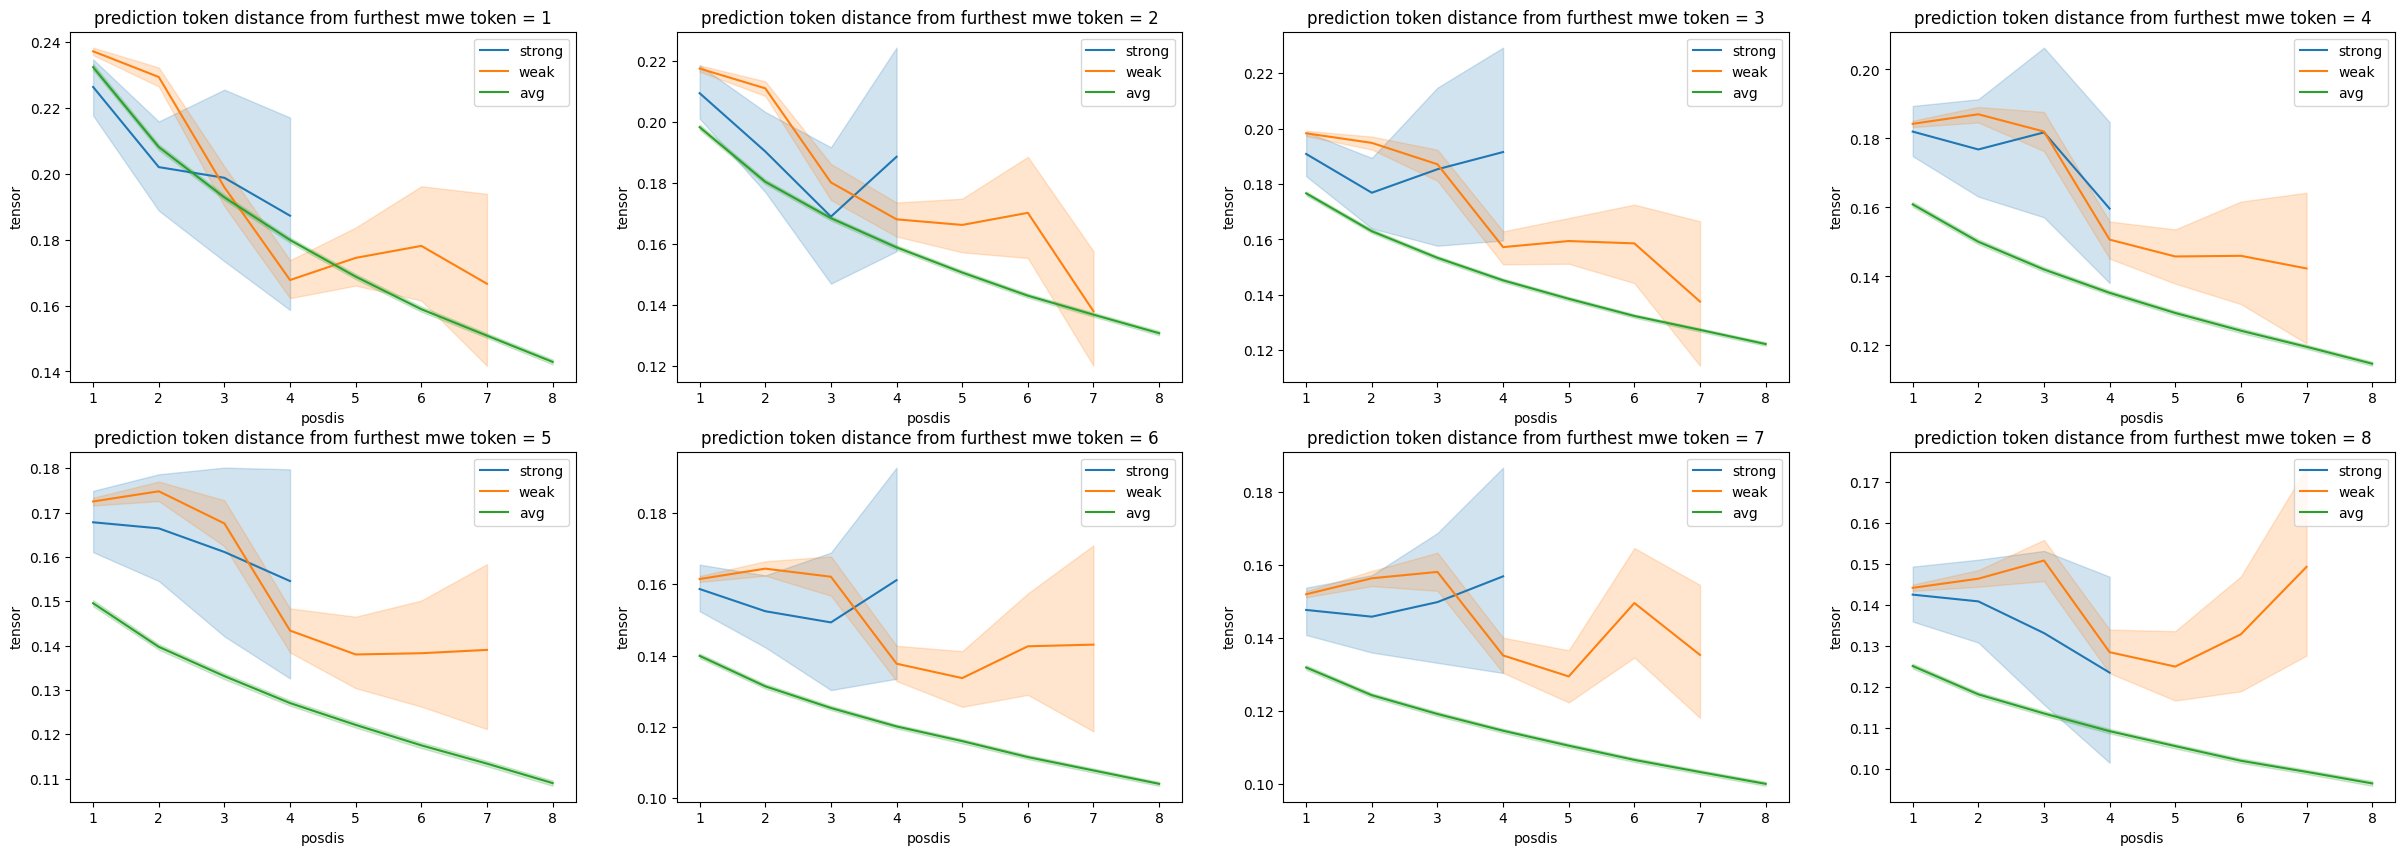

In [31]:
fig, axes = plt.subplots(2, 4, figsize=(30,10))

for i in range(0, 4):
    for j in [0,1]:
        min_dist = j*4 + i + 1
        
        strong_line = sns.lineplot(data=strong_df[strong_df['min_dist'] ==min_dist], x="posdis", y="tensor", ax=axes[j][i], label='strong')
        weak_line = sns.lineplot(data=weak_df[weak_df['min_dist'] ==min_dist], x="posdis", y="tensor", ax=axes[j][i], label='weak')
        avg_line = sns.lineplot(data=avg_df[avg_df['min_dist'] == min_dist], x="posdis", y="tensor", ax=axes[j][i], label='avg')
        # axes[j][i].set_title('Comparison of strong vs avg vs weak mwe over fixed positional distances')
        axes[j][i].set_title(f'prediction token distance from furthest mwe token = {min_dist}')
        axes[j][i].legend()

In [33]:
def fix_df(df):
    df['min_dist'] = df['predicted_token_dist_from_start'] - df[['first_token', 'second_token']].max(axis=1)
    df['max_dist'] = df['predicted_token_dist_from_start'] - df[['first_token', 'second_token']].min(axis=1)
    df['count'] = df.groupby('min_dist')['posdis'].transform(lambda x : x.count())
    df = df[df['count']>=200].copy()
    # abc = df.groupby(['posdis','min_dist'])['tensor'].mean().reset_index()
    return df

In [34]:
print(len(strong_df))

46412


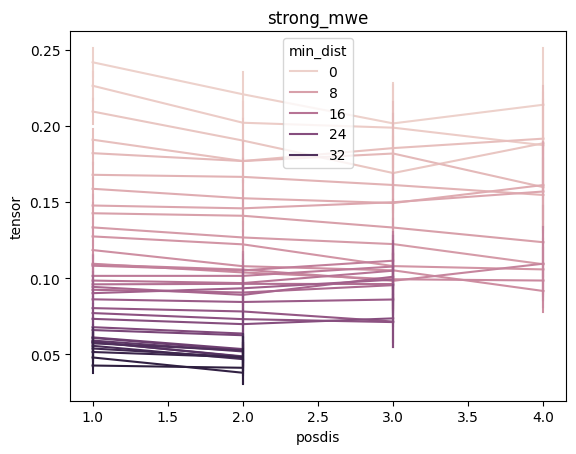

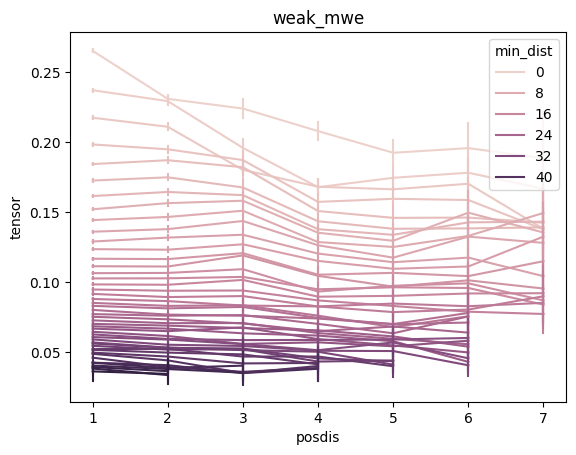

In [37]:
abc_s = fix_df(strong_df)
abc_w = fix_df(weak_df)

strong_line = sns.lineplot(data=abc_s, x="posdis", y="tensor", hue='min_dist', err_style='bars',legend=True, errorbar=('ci', 95))
plt.title('strong_mwe')
plt.show()
weak_line = sns.lineplot(data=abc_w, x="posdis", y="tensor", hue='min_dist', err_style='bars',legend=True, errorbar=('ci', 95))
plt.title('weak_mwe')
plt.show()

In [ ]:
def mean_plot2():
    strong_df = f_df('strong_mwe_distance_3d.pkl')
    weak_df = f_df('weak_mwe_distance_3d.pkl')
    avg_df = f_avg_df('average_distance_3d.pkl')
    fig, ax = plt.subplots()
    strong_line = sns.lineplot(data=strong_df, x="posdis", y="tensor", ax=ax, label='strong')
    weak_line = sns.lineplot(data=weak_df, x="posdis", y="tensor", ax=ax, label='weak')
    avg_line = sns.lineplot(data=avg_df, x="posdis", y="tensor", ax=ax, label='avg')
    ax.set_title('Comparison of strong vs avg vs weak mwe over fixed positional distances')
    ax.legend()

,I,posdis,row_number,tokens,first_token,second_token
0,"([tensor(0.0469), tensor(0.0369), tensor(0.137...",1,0,"[0, 1]",0,1
1,"([tensor(0.0404), tensor(0.1462), tensor(0.109...",2,0,"[0, 2]",0,2
2,"([tensor(0.1200), tensor(0.0935), tensor(0.055...",3,0,"[0, 3]",0,3
3,"([tensor(0.1122), tensor(0.0602)], 5)",4,0,"[0, 4]",0,4
4,"([tensor(0.0450)], 6)",5,0,"[0, 5]",0,5
...,...,...,...,...,...,...
655686,"([tensor(0.2261), tensor(0.0643), tensor(0.282...",2,7802,"[5, 7]",5,7
655687,"([tensor(0.1715), tensor(0.5096), tensor(0.050...",3,7802,"[5, 8]",5,8
655688,"([tensor(0.5729), tensor(0.0506), tensor(0.057...",4,7802,"[5, 9]",5,9
655689,"([tensor(0.3408), tensor(0.4046), tensor(0.421...",1,7802,"[6, 7]",6,7


In [ ]:
sns.lineplot(data=flights, x="year", y="passengers")

In [ ]:
import pandas as pd
abc = pd.read_pickle('weak_mwe_distance_3d.pkl')
abc['first_token'] = abc.apply(lambda x : x['ignore'][x['first_token']], axis=1)
abc['second_token'] = abc.apply(lambda x : x['ignore'][x['second_token']], axis=1)
abc['predicted_token_dist_from_start'] = abc.apply(lambda x : list(range(x['I'][1], x['I'][1] + len(x['I'][0]))), axis=1)
abc['tensor'] = abc.apply(lambda x : x['I'][0], axis=1)
abc = abc.explode(['predicted_token_dist_from_start', 'tensor']).drop(columns = ['I'])

In [37]:
abc

,posdis,ignore,row_number,first_token,second_token,predicted_token_dist_from_start,tensor
0,1,"[2, 3, 4, 5]",0,3,2,4,tensor(0.5223)
0,1,"[2, 3, 4, 5]",0,3,2,5,tensor(0.1699)
0,1,"[2, 3, 4, 5]",0,3,2,6,tensor(0.0933)
1,2,"[2, 3, 4, 5]",0,4,2,5,tensor(0.2600)
1,2,"[2, 3, 4, 5]",0,4,2,6,tensor(0.0877)
...,...,...,...,...,...,...,...
20118,1,"[23, 24]",10262,24,23,25,tensor(0.6320)
20118,1,"[23, 24]",10262,24,23,26,tensor(0.2334)
20118,1,"[23, 24]",10262,24,23,27,tensor(0.2014)
20118,1,"[23, 24]",10262,24,23,28,tensor(0.6512)
